# CDK2 protein
# Data load and preprocessing

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [298]:
%run ./1_Helper_functions.ipynb

In [299]:
protein_name='cdk2'
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

R_a = round(y.sum() / len(y), 2)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(3466, 402)
415
Ra = 0.12


## Estimators
### ML Classifiers

In [300]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified", "random_state": 42}
dclf = DummyClassifier(**hyparams)

In [301]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

### naive Bayes Classifiers

In [302]:
from sklearn.naive_bayes import GaussianNB

hyparams ={}
nb_g = GaussianNB(**hyparams)

In [303]:
from sklearn.naive_bayes import ComplementNB 

hyparams ={}
nb_c = ComplementNB(**hyparams)

In [304]:
# ML Classifier
ml_classifiers = {
    'xgb': xgb,
    'dclf': dclf,
    'nb_g': nb_g
#     'nb_c': nb_c,
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [305]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [306]:
estimators = {**ml_classifiers, **cs_functions}

### Evaluation metrics 

In [307]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': 0.12, 'method':'normalized'}
            )

# Hold-out Validation 

### 30 replicas


In [308]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def n_hold_out_validation_SAVE(filename, **kwargs):
    return n_hold_out_validation(**kwargs)

In [309]:
%%time
evaluation_name='ho30_bayes_classifiers_test'
ho30 = n_hold_out_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X, y=y, metrics=metrics, 
                      n_reps=30, random_state=42)

full_names = ['XGB', 'DummyClf', 'nB_Gaus',  'csMEAN']
new_names = dict(zip(
    [*ho30.columns],
    full_names))

ho30 = ho30.rename(columns=new_names)

File loaded: ./cachedir/ho30_bayes_classifiers_test_cdk2
CPU times: user 4.95 ms, sys: 7 µs, total: 4.96 ms
Wall time: 16.7 ms


In [310]:
%run Friedman_and_Nemenyi_test.ipynb
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## AUC-ROC

In [311]:
# ROC-AUC
metric_name='roc_auc'

# Normality
display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))

display(friedmanTest(ho30.loc[metric_name]))

df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.25, random_state=42)

,XGB,DummyClf,nB_Gaus,csMEAN
Normality,1,1,1,1


,statistic,p
Bartlett,22.324523,0.000056


,chi^2,dof,p_value
Friedman Test,81.64,3,1.365262e-17


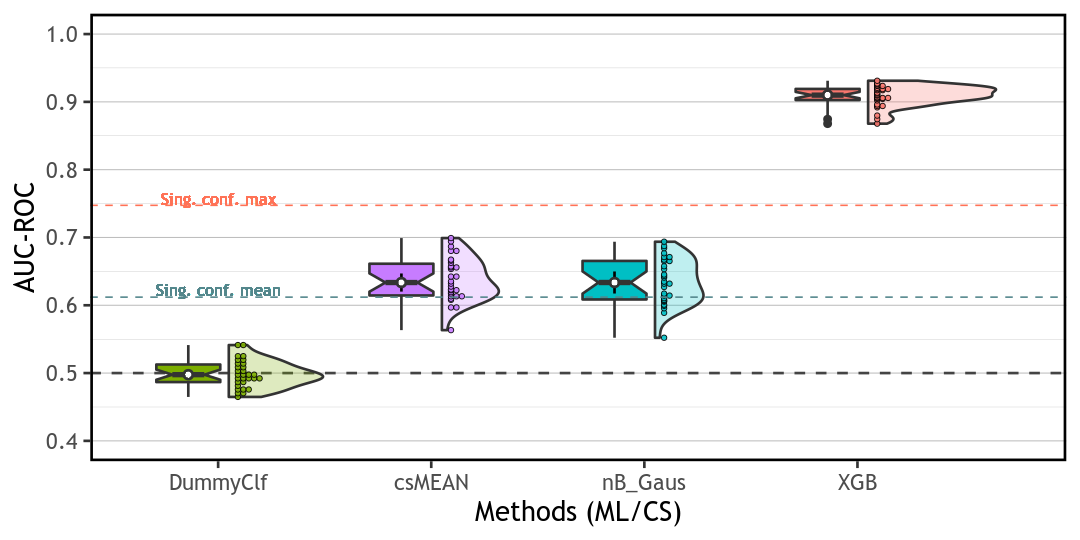

In [312]:
%%R -i full_names -i df_R -i single_mean -i single_max  -w 6 -h 3 --units in -r 180

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.4, y_max=1.) +
add_ref_values('Sing. conf. mean', single_mean, color='cadetblue4') + 
add_ref_values('Sing. conf. max', single_max, color='coral1')

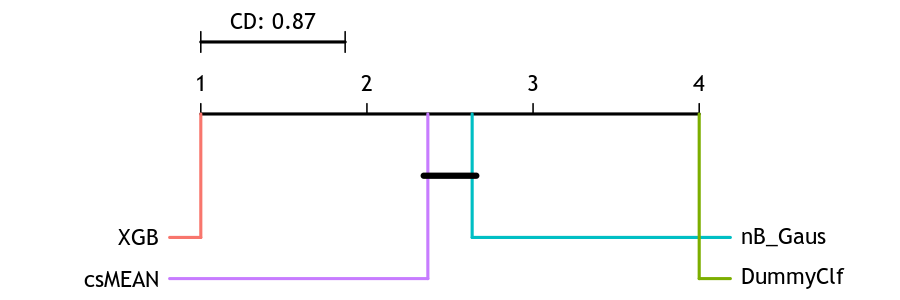

In [313]:
%%R -i df_R -i full_names -w 6 -h 2 --units in -r 150
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

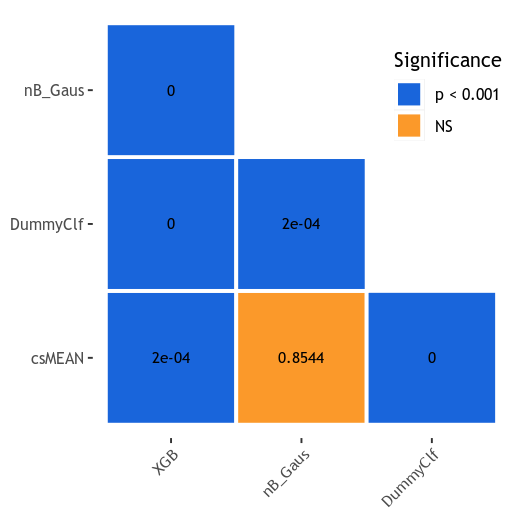

In [314]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

# Using only the conformations reported by Tian

Subset the conformations used by Tian 2014

In [315]:
tian_confs = ['3ddq', '3pxf', '4fkl', '4gcj']

# Simplify the names
display(X_merged_dksc[tian_confs].head())
X_tian = X_merged_dksc[tian_confs].values
y = y_true_merged.values

3ddq  3pxf  4fkl  4gcj
library name                        
COCRYS  STU   -7.2  -6.5  -5.8  -6.7
        ATP   -7.1  -9.2  -8.6  -8.8
        PVB   -7.7  -8.4  -6.8  -7.7
        DTQ   -8.4  -9.1  -7.7  -8.4
        HMD   -7.4  -7.5  -5.9  -6.5

In [316]:
%%time
evaluation_name='ho30_bayes_classifiers_TIAN_CONFS'
ho30_tian = n_hold_out_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X_tian, y=y, metrics=metrics, 
                      n_reps=30, random_state=42)

full_names = ['XGB', 'DummyClf', 'nB_Gaus',  'csMEAN']
new_names = dict(zip(
    [*ho30_tian.columns],
    full_names))

ho30_tian = ho30_tian.rename(columns=new_names)

File loaded: ./cachedir/ho30_bayes_classifiers_TIAN_CONFS_cdk2
CPU times: user 6.94 ms, sys: 23 µs, total: 6.96 ms
Wall time: 20.3 ms


In [317]:
# ROC-AUC
metric_name='roc_auc'

# Normality
display(multi_norm_test(ho30_tian, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30_tian, metric=metric_name))

display(friedmanTest(ho30_tian.loc[metric_name]))

df_R = order_df(ho30_tian, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X_tian, y, 
                            metrics[metric_name], n_reps=30, test_size=0.25, random_state=42)

,XGB,DummyClf,nB_Gaus,csMEAN
Normality,1,1,1,1


,statistic,p
Bartlett,5.619021,0.131691


,chi^2,dof,p_value
Friedman Test,88.84,3,3.887693e-19


R[write to console]: notch went outside hinges. Try setting notch=FALSE.



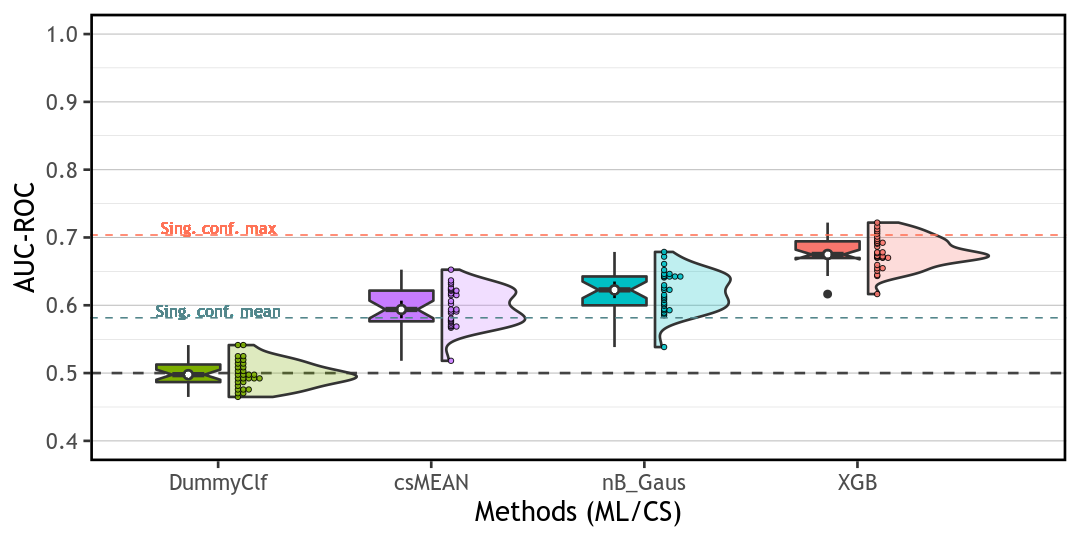

In [318]:
%%R -i full_names -i df_R -i single_mean -i single_max  -w 6 -h 3 --units in -r 180

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.4, y_max=1.) +
add_ref_values('Sing. conf. mean', single_mean, color='cadetblue4') + 
add_ref_values('Sing. conf. max', single_max, color='coral1')

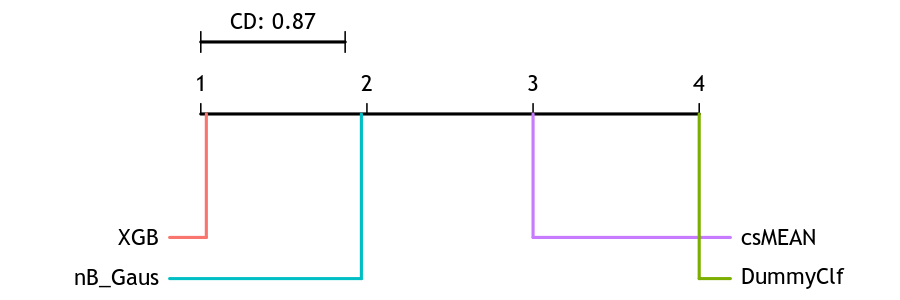

In [319]:
%%R -i df_R -i full_names -w 6 -h 2 --units in -r 150
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

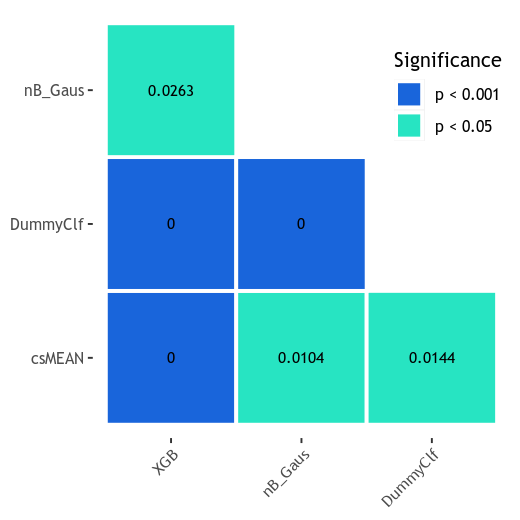

In [320]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

# Active/inactive scores distribution
We will compare against the Tian (2014), fig. 4

In [321]:
tian_confs = ['3ddq', '3pxf', '4fkl', '4gcj']

# Simplify the names
X_tian = X_merged_dksc[tian_confs].copy()
# add the y variable
X_tian['activity'] = y

Get the AUC-ROC values

In [349]:
auc_all = PlotMetric(y, 
                           X_merged_dksc.to_dict('list'),
                decreasing=True)\
                .format_metric_results(
                    rounded=5,
                    metric_name='roc_auc')
auc_all.loc[tian_confs]

,ROC AUC
3ddq,0.64140
3pxf,0.54138
4fkl,0.54002
4gcj,0.58710


Actives Normality


ShapiroResult(statistic=0.9631178975105286, pvalue=1.0523625526559499e-08)

Inactives Normality


ShapiroResult(statistic=0.9709023237228394, pvalue=1.987633658317492e-24)

t-student test


Ttest_indResult(statistic=-8.87346992637901, pvalue=1.1141222084258025e-18)

Bartlett test


BartlettResult(statistic=8.478169270891387, pvalue=0.0035943363711437933)

AUC-ROC


ROC AUC    0.6414
Name: 3ddq, dtype: float64

MannwhitneyuResult(statistic=454046.5, pvalue=3.803029724456216e-21)

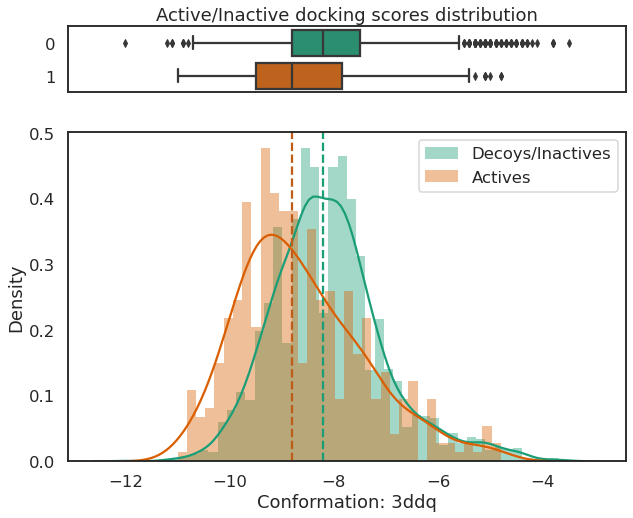

In [357]:
compare_two_distributions('3ddq')

Actives Normality


ShapiroResult(statistic=0.9887440204620361, pvalue=0.002765678334981203)

Inactives Normality


ShapiroResult(statistic=0.9831254482269287, pvalue=1.3260731957160365e-18)

t-student test


Ttest_indResult(statistic=-2.4462292307688993, pvalue=0.014485321901983619)

Bartlett test


BartlettResult(statistic=19.212437575470968, pvalue=1.1694894250140836e-05)

AUC-ROC


ROC AUC    0.54002
Name: 4fkl, dtype: float64

MannwhitneyuResult(statistic=582408.0, pvalue=0.004012232815895594)

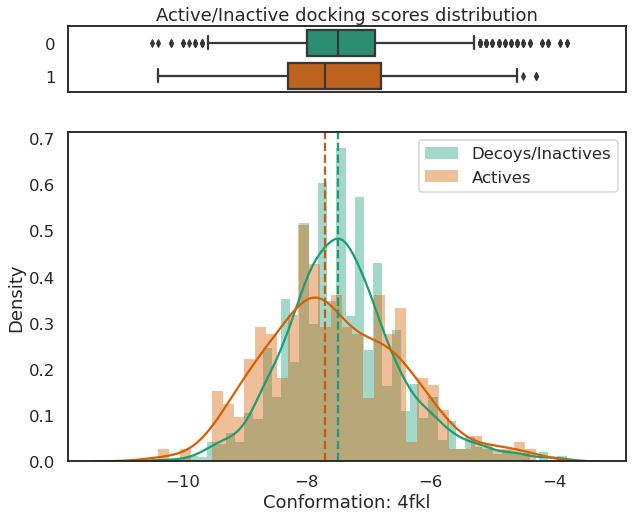

In [358]:
compare_two_distributions('4fkl')